In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"C:\Users\moral\Dropbox\Panda\WORK\Research\FSPM\Virtual_Plant_Laboratory\Julia\VPLsite\tutorials\forest"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| eval: false
import Pkg
Pkg.add("Distributions")
Pkg.add("Plots")

In [3]:
using VPL
using Distributions, Plots
# Data types
module TreeTypes
    import VPL
    # Meristem
    struct Meristem <: VPL.Node end
    # Bud
    struct Bud <: VPL.Node end
    # Node
    struct Node <: VPL.Node end
    # BudNode
    struct BudNode <: VPL.Node end
    # Internode (needs to be mutable to allow for changes over time)
    Base.@kwdef mutable struct Internode <: VPL.Node
        length::Float64 = 0.10 # Internodes start at 10 cm
    end
    # Leaf
    Base.@kwdef struct Leaf <: VPL.Node
        length::Float64 = 0.20 # Leaves are 20 cm long
        width::Float64  = 0.1 # Leaves are 10 cm wide
    end    
    # Graph-level variables
    Base.@kwdef struct treeparams
        growth::Float64 = 0.1   
        budbreak::Float64 = 0.25
        phyllotaxis::Float64 = 140.0
        leaf_angle::Float64 = 30.0
        branch_angle::Float64 = 45.0
    end
end

import .tree

# Create geometry + color for the internodes
function VPL.feed!(turtle::Turtle, i::TreeTypes.Internode, vars)
    # Rotate turtle around the head to implement elliptical phyllotaxis
    rh!(turtle, vars.phyllotaxis) 
    HollowCylinder!(turtle, length = i.length, height = i.length/15, width = i.length/15, 
                move = true, color = RGB(0.5,0.4,0.0))
    return nothing
end

# Create geometry + color for the leaves
function VPL.feed!(turtle::Turtle, l::TreeTypes.Leaf, vars)
    # Rotate turtle around the arm for insertion angle
    ra!(turtle, -vars.leaf_angle)
    # Generate the leaf 
    Ellipse!(turtle, length = l.length, width = l.width, move = false, 
             color = RGB(0.2,0.6,0.2))
    # Rotate turtle back to original direction
    ra!(turtle, vars.leaf_angle)
    return nothing
end

# Insertion angle for the bud nodes
function VPL.feed!(turtle::Turtle, b::TreeTypes.BudNode, vars)
    # Rotate turtle around the arm for insertion angle
    ra!(turtle, -vars.branch_angle)
end


# Rules
meristem_rule = Rule(TreeTypes.Meristem, rhs = mer -> TreeTypes.Node() + 
                                              (TreeTypes.Bud(), TreeTypes.Leaf()) +
                                         TreeTypes.Internode() + TreeTypes.Meristem())

function prob_break(bud)
    # We move to parent node in the branch where the bud was created
    node =  parent(bud)
    # We count the number of internodes between node and the first Meristem 
    # moving down the graph
    check, steps = hasDescendent(node, condition = n -> data(n) isa TreeTypes.Meristem)
    steps = Int(ceil(steps/2)) # Because it will count both the nodes and the internodes
    # Compute probability of bud break and determine whether it happens
    if check
        prob =  min(1.0, steps*vars(bud).budbreak)
        return rand() < prob
    # If there is no meristem, an error happened since the model does not allow for this    
    else
        error("No meristem found in branch")
    end
end
branch_rule = Rule(TreeTypes.Bud, 
            lhs = prob_break, 
            rhs = bud -> TreeTypes.BudNode() + TreeTypes.Internode() + TreeTypes.Meristem())

Rule replacing nodes of type Main.TreeTypes.Bud without context capturing.


In [4]:
function create_tree(origin, growth, budbreak, orientation)
    axiom = T(origin) + RH(orientation) + TreeTypes.Internode() + TreeTypes.Meristem()
    tree =  Graph(axiom = axiom, rules = (meristem_rule, branch_rule), 
                  vars = TreeTypes.treeparams(growth = growth, budbreak = budbreak))
    return tree
end

create_tree (generic function with 1 method)

In [5]:
getInternode = Query(TreeTypes.Internode)

function elongate!(tree, query)
    for x in apply(tree, query)
        x.length = x.length*(1.0 + vars(tree).growth)
    end
end

function growth!(tree, query)
    elongate!(tree, query)
    rewrite!(tree)
end

function simulate(tree, query, nsteps)
    new_tree = deepcopy(tree)
    for i in 1:nsteps
        growth!(new_tree, query)
    end
    return new_tree
end

simulate (generic function with 1 method)

In [6]:
origins = [Vec(i,j,0) for i = 1:2.0:20.0, j = 1:2.0:20.0]

10×10 Matrix{StaticArraysCore.SVector{3, Float64}}:
 [1.0, 1.0, 0.0]   [1.0, 3.0, 0.0]   [1.0, 5.0, 0.0]   …  [1.0, 19.0, 0.0]
 [3.0, 1.0, 0.0]   [3.0, 3.0, 0.0]   [3.0, 5.0, 0.0]      [3.0, 19.0, 0.0]
 [5.0, 1.0, 0.0]   [5.0, 3.0, 0.0]   [5.0, 5.0, 0.0]      [5.0, 19.0, 0.0]
 [7.0, 1.0, 0.0]   [7.0, 3.0, 0.0]   [7.0, 5.0, 0.0]      [7.0, 19.0, 0.0]
 [9.0, 1.0, 0.0]   [9.0, 3.0, 0.0]   [9.0, 5.0, 0.0]      [9.0, 19.0, 0.0]
 [11.0, 1.0, 0.0]  [11.0, 3.0, 0.0]  [11.0, 5.0, 0.0]  …  [11.0, 19.0, 0.0]
 [13.0, 1.0, 0.0]  [13.0, 3.0, 0.0]  [13.0, 5.0, 0.0]     [13.0, 19.0, 0.0]
 [15.0, 1.0, 0.0]  [15.0, 3.0, 0.0]  [15.0, 5.0, 0.0]     [15.0, 19.0, 0.0]
 [17.0, 1.0, 0.0]  [17.0, 3.0, 0.0]  [17.0, 5.0, 0.0]     [17.0, 19.0, 0.0]
 [19.0, 1.0, 0.0]  [19.0, 3.0, 0.0]  [19.0, 5.0, 0.0]     [19.0, 19.0, 0.0]

In [7]:
orientations = [rand()*360.0 for i = 1:2.0:20.0, j = 1:2.0:20.0]

10×10 Matrix{Float64}:
 222.364    56.1871   73.6958   211.862  …  130.115    344.038    32.8873
 154.005   335.147   169.658    145.118     349.254    352.288   266.972
  68.072   176.615    24.559    255.41       77.6074   147.983   221.462
 279.666   199.964    11.9299   213.552     319.111    343.475    31.4013
 204.262   132.813   290.499    228.254      12.5165   318.611   314.992
 238.702    39.1609  184.871    254.784  …   55.7255   344.87     29.7259
  84.3218   90.7604  245.653    351.928       7.75052  181.514   221.39
  47.6947   63.7208   11.6989   253.712     222.514     76.2133  344.47
 142.708   334.947    17.3572   156.411     328.684    307.71    359.628
 212.032    31.1857    7.74511  204.149     108.154    290.019   266.78

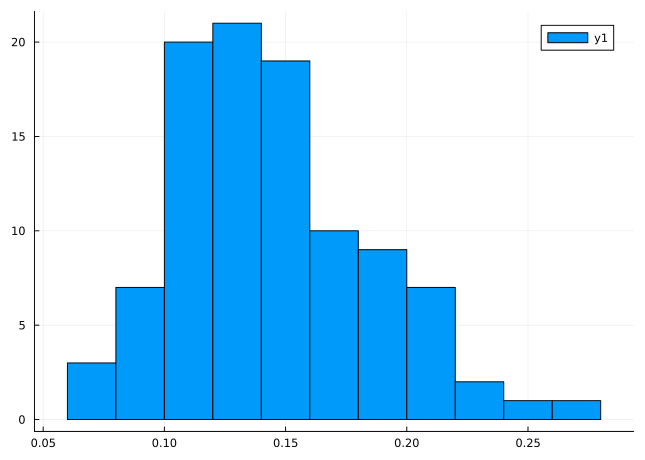

In [8]:
growths = rand(LogNormal(-2, 0.3), 10, 10)
histogram(vec(growths))

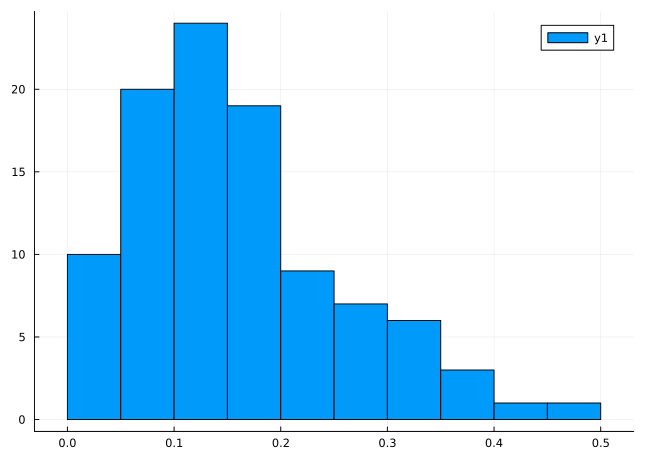

In [9]:
budbreaks = rand(Beta(2.0, 10), 10, 10)
histogram(vec(budbreaks))

In [10]:
forest = vec(create_tree.(origins, growths, budbreaks, orientations));

In [11]:
newforest = [simulate(tree, getInternode, 2) for tree in forest];

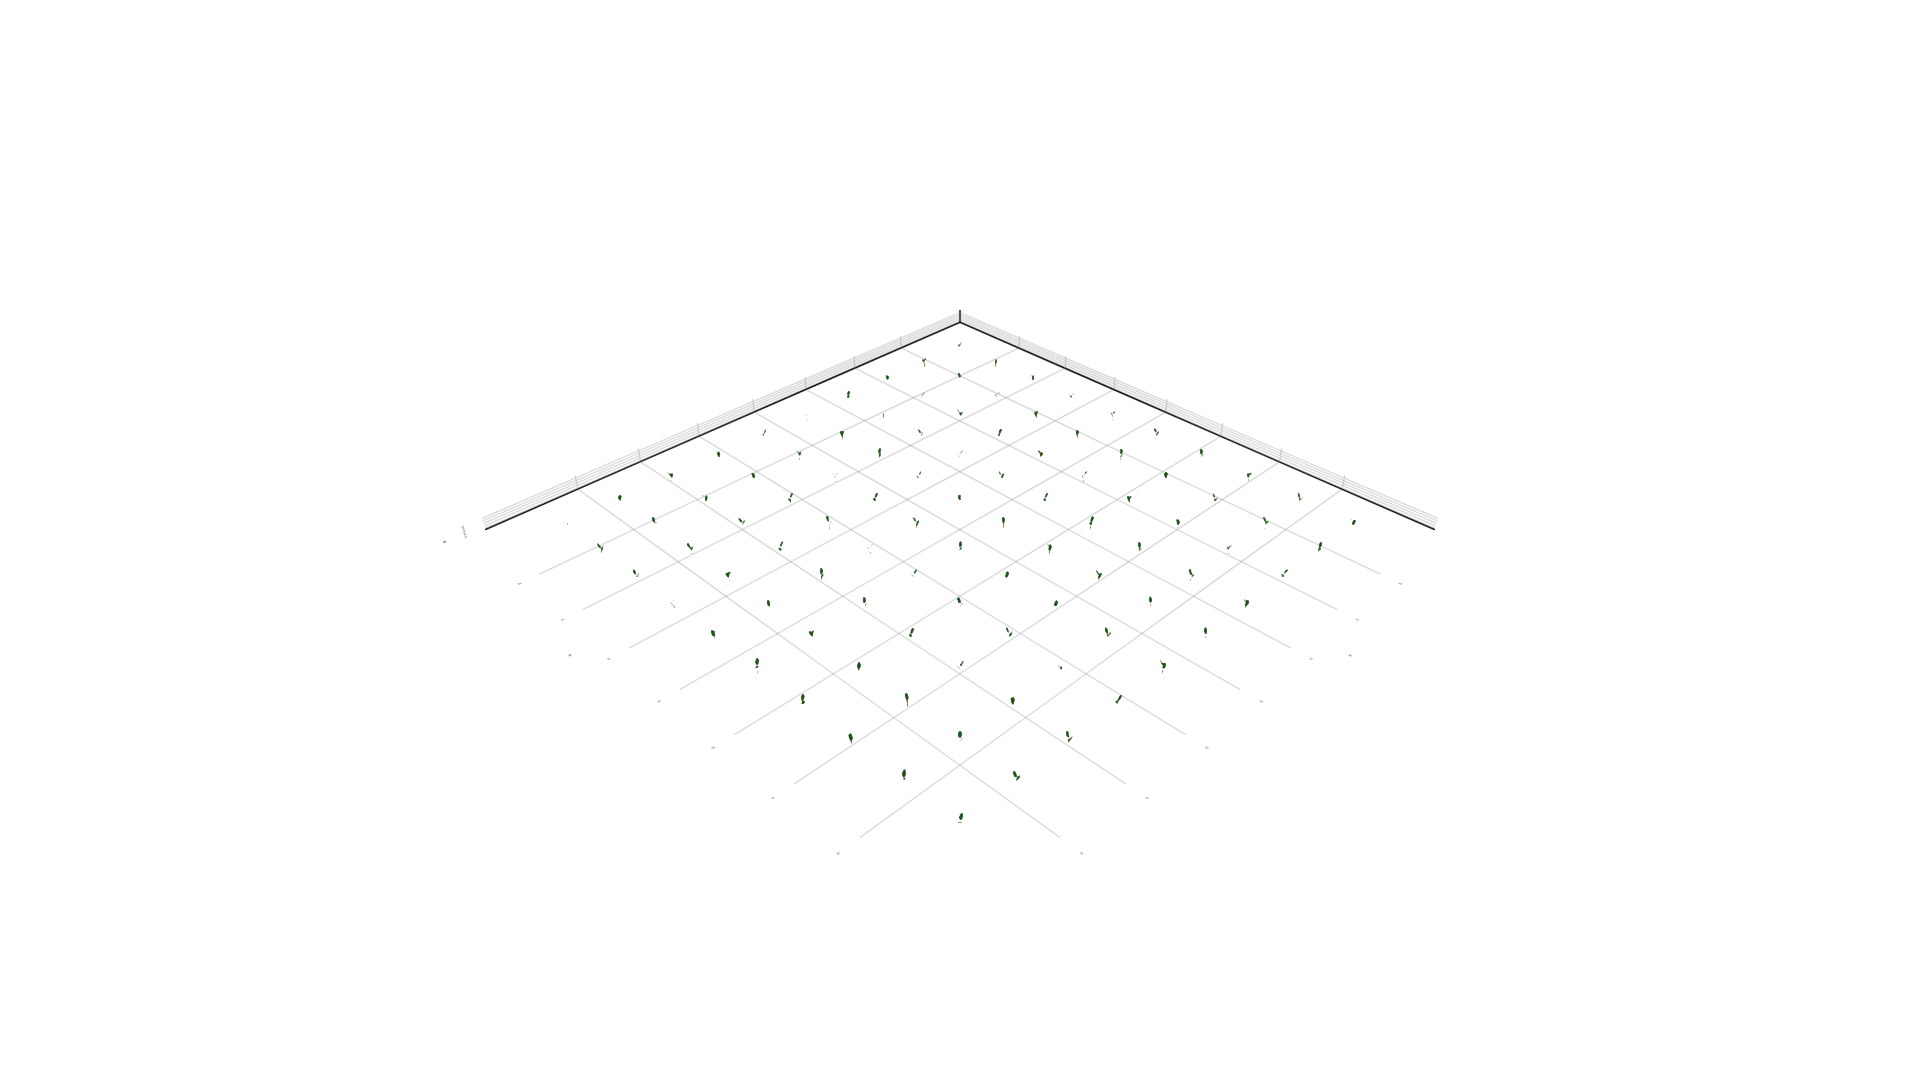

In [12]:
render(newforest)

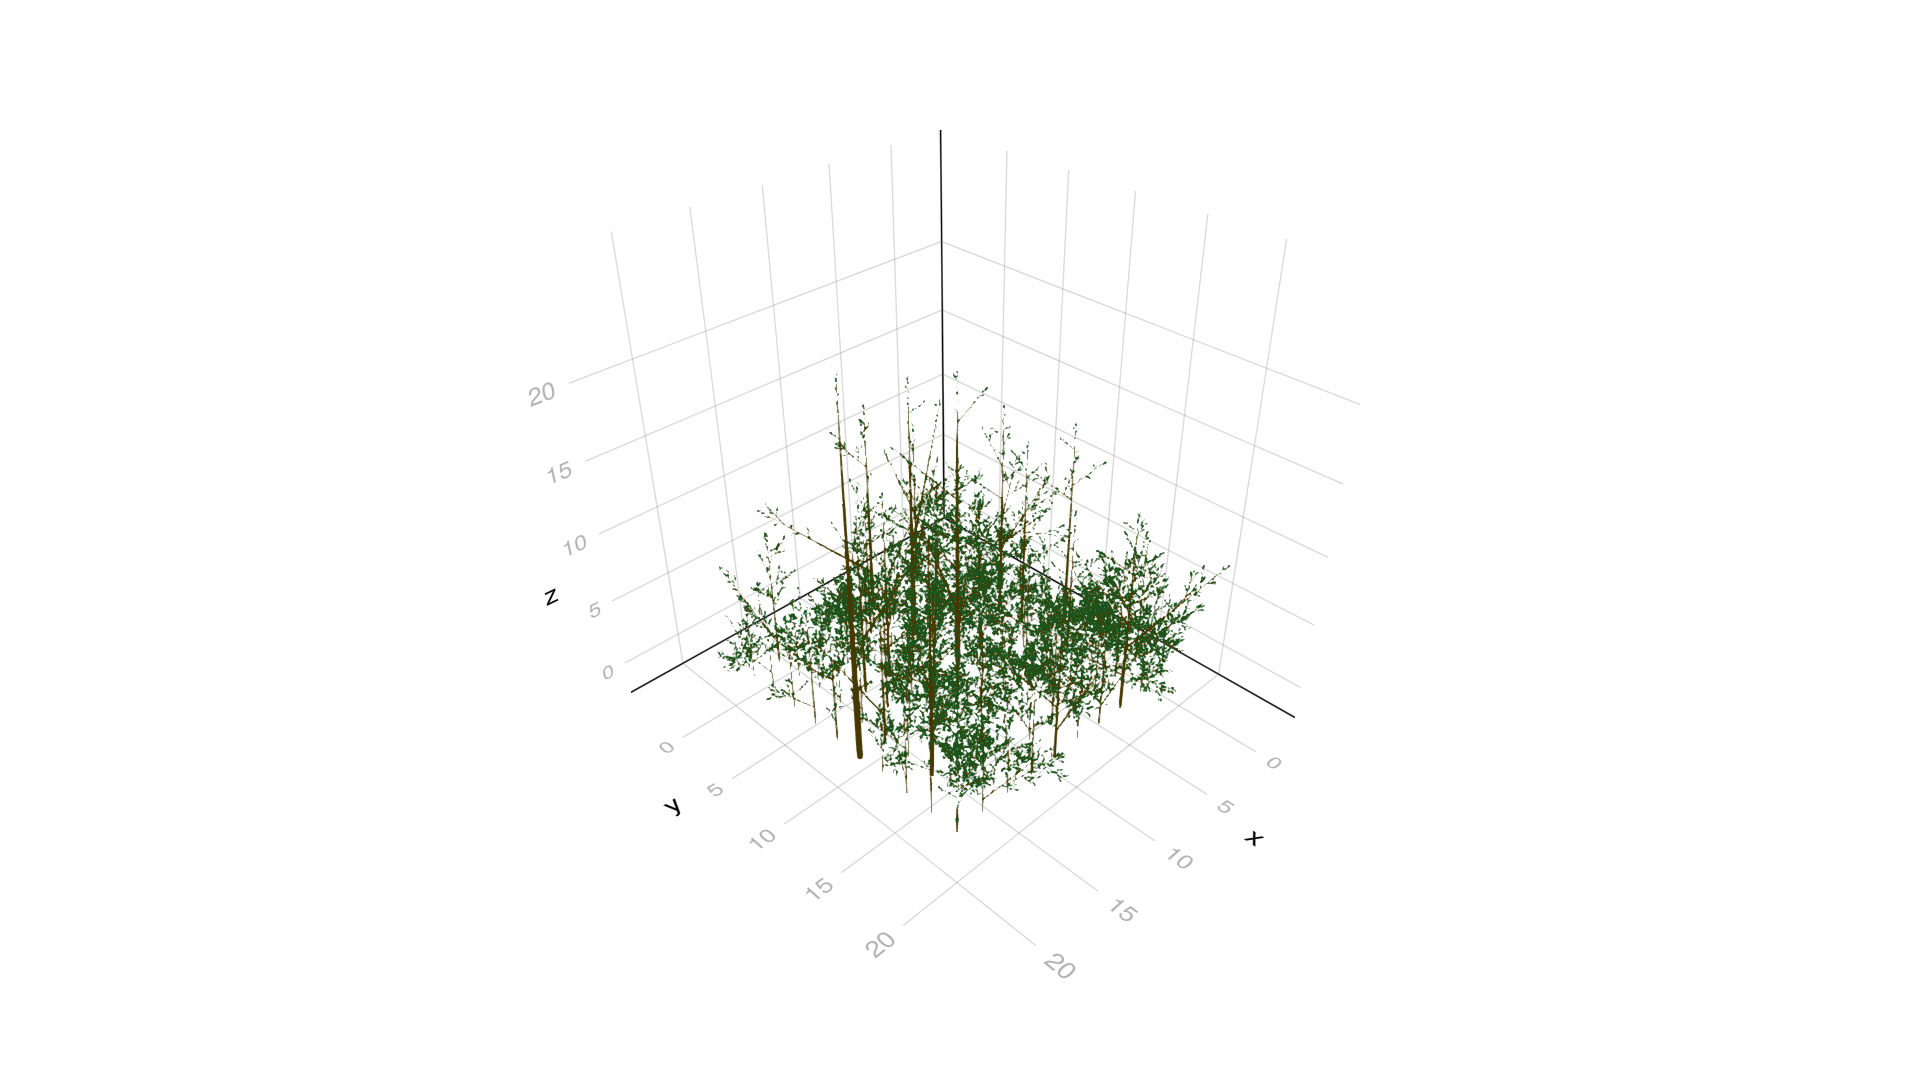

In [13]:
newforest = [simulate(tree, getInternode, 15) for tree in newforest];
render(newforest)

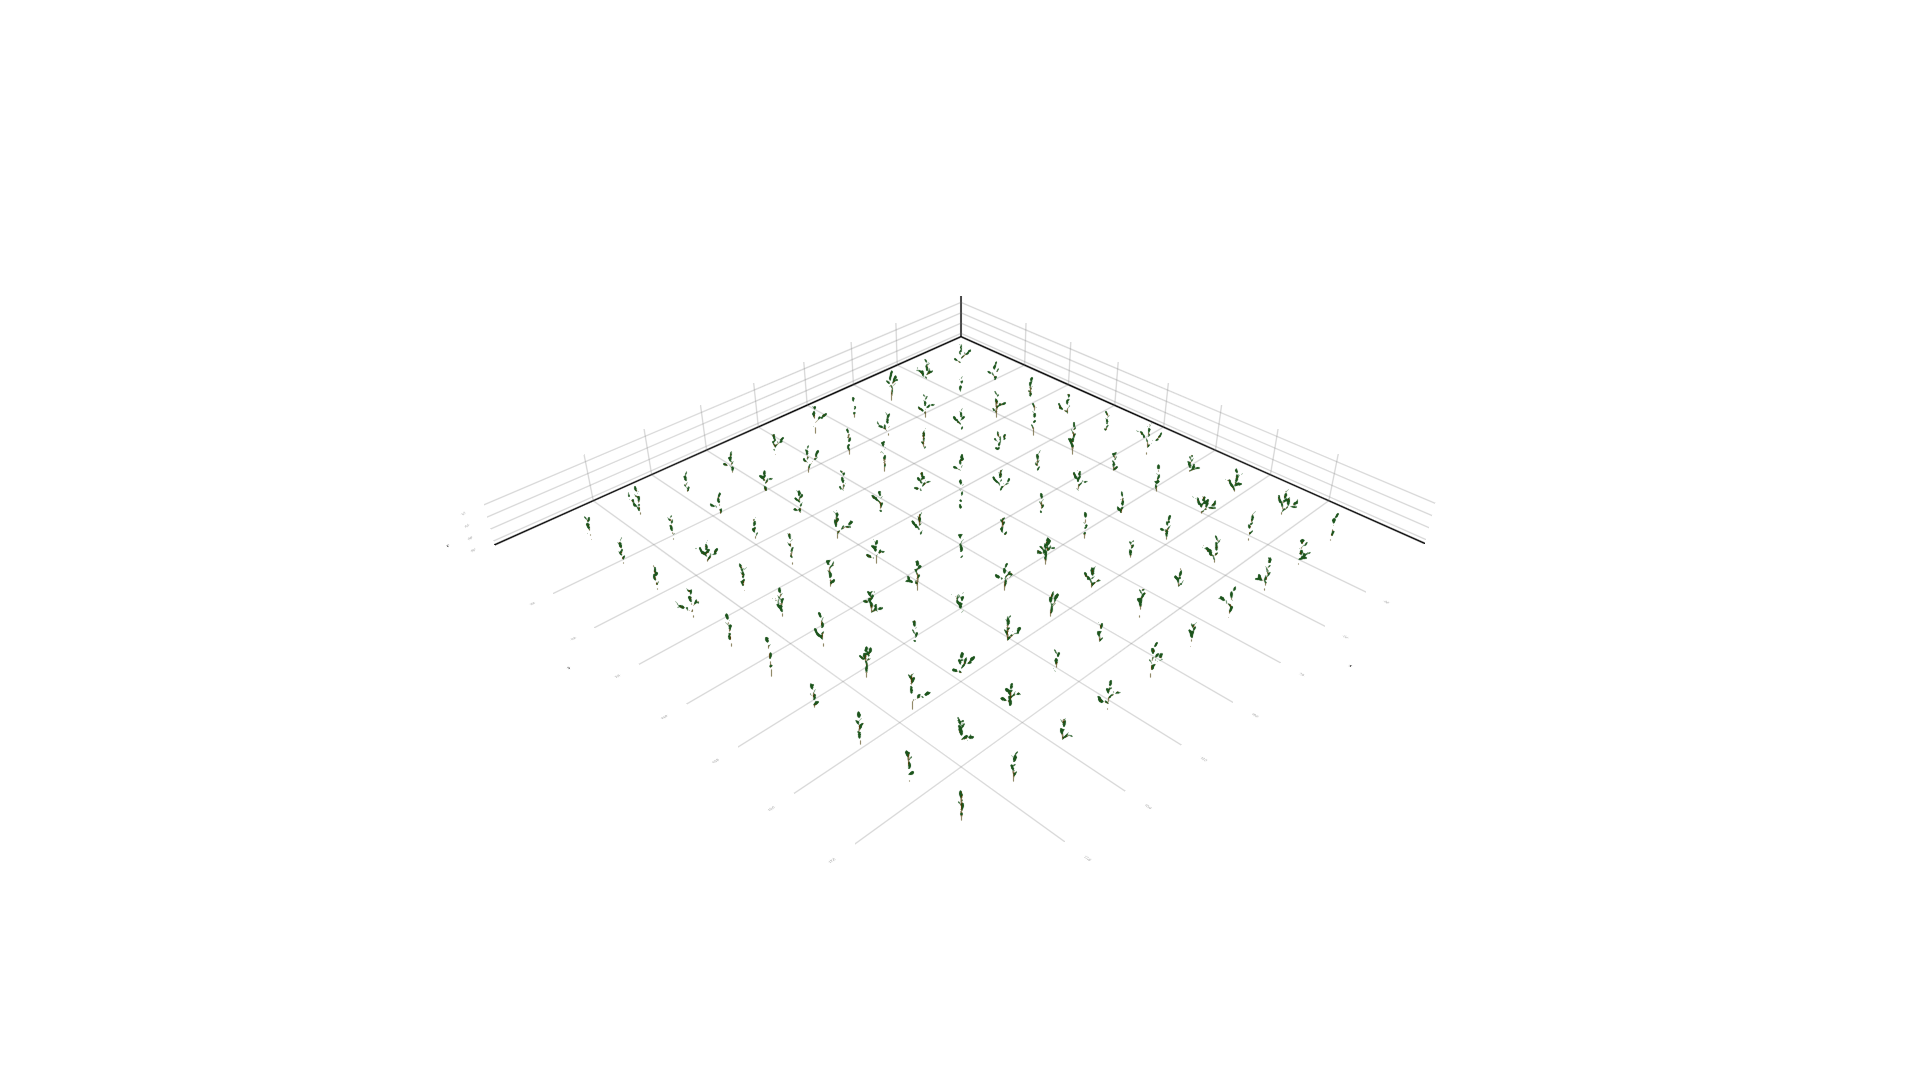

In [14]:
using Base.Threads
newforest = deepcopy(forest)
@threads for i in 1:length(forest)
    newforest[i] = simulate(forest[i], getInternode, 6)
end
render(newforest, parallel = true)

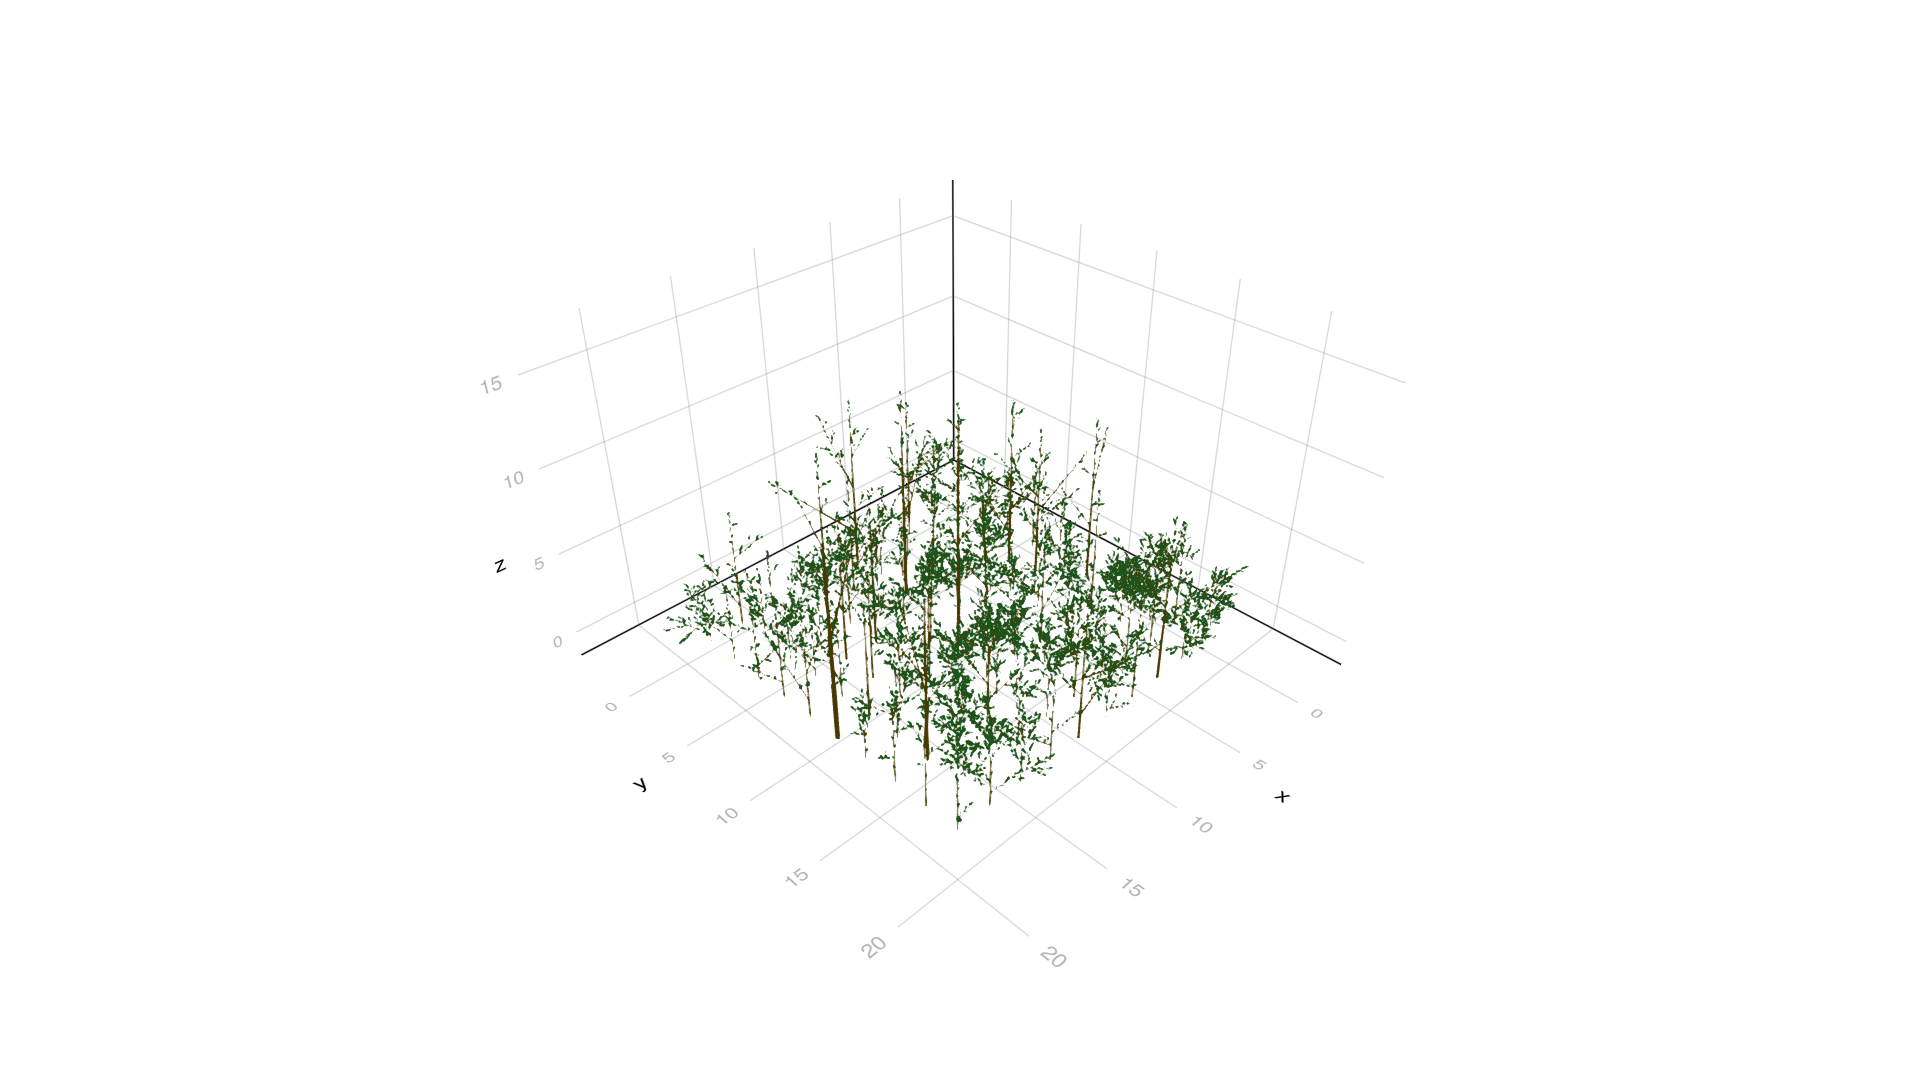

In [15]:
newforest = deepcopy(forest)
for step in 1:15
    @threads for i in 1:length(newforest)
        newforest[i] = simulate(newforest[i], getInternode, 1)
    end
end
render(newforest, parallel = true)

In [16]:
scene = Scene(newforest);

In [17]:
soil = Rectangle(length = 21.0, width = 21.0)
rotatey!(soil, pi/2)
VPL.translate!(soil, Vec(0.0, 10.5, 0.0))

In [18]:
VPL.add!(scene, mesh = soil, color = RGB(1,1,0))

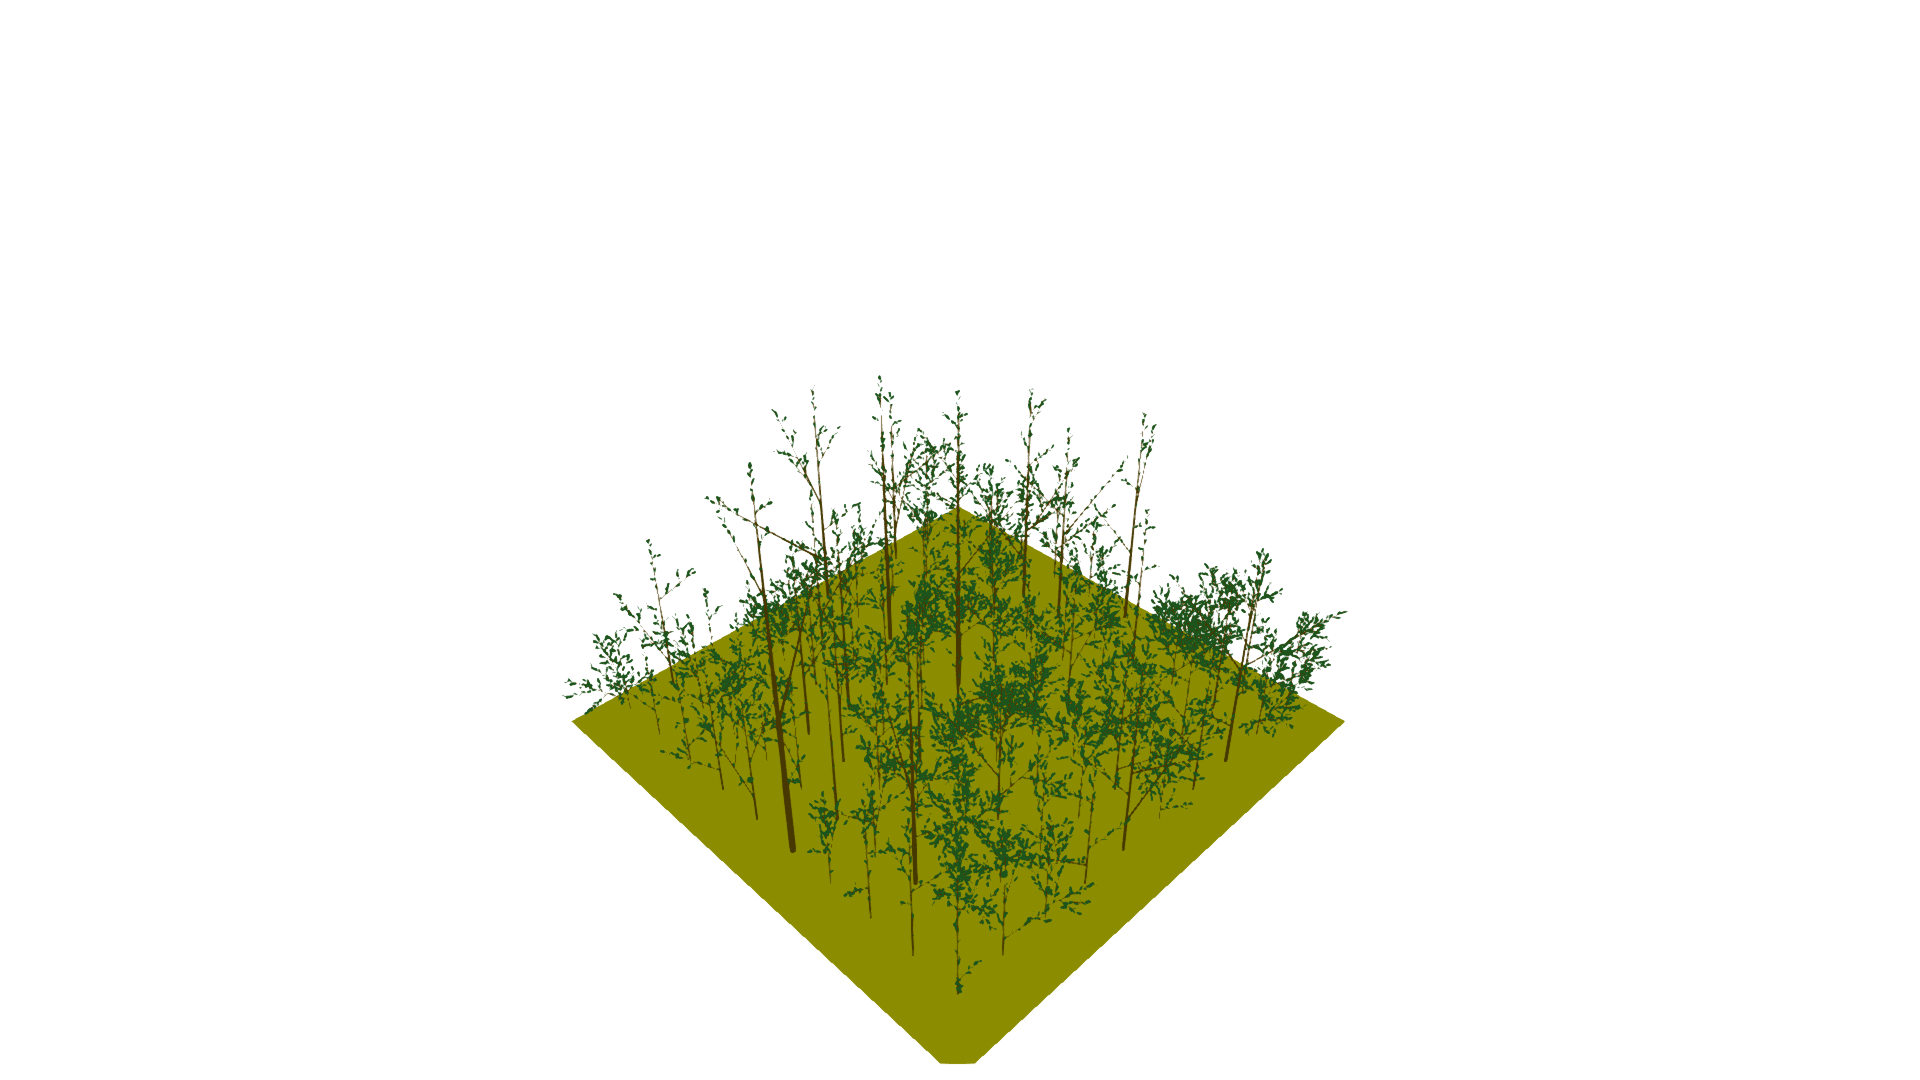

In [19]:
render(scene, axes = false)

In [20]:
#| eval: false
res = calculate_resolution(width = 16.0, height = 16.0, dpi = 1_000)
output = render(scene, axes = false, resolution = res)
export_scene(scene = output, filename = "nice_trees.png") 